University of Helsinki, Master's Programme in Data Science  
DATA20019 Trustworthy Machine Learning, Autumn 2021  
Antti Honkela and Ossi Räisä  

# Project 2: Real-life privacy-preserving machine learning

Deadline for returning the solutions: 28 November 23:55.

## General instructions (IMPORTANT!)

1. This is an individual project. You can discuss the solutions with other students, but everyone needs to write their own code and answers.
2. Please return your solutions as a notebook. When returning your solutions, please leave all output in the notebook.
3. When returning your solutions, please make sure the notebook can be run cleanly using "Cell" / "Run All".
4. Please make sure there are no dependencies between solutions to different problems.
5. Please make sure that your notebook will not depend on any local files.
6. Please make sure that the solutions for each problem in your notebook will produce the same results when run multiple times, i.e. remember to seed any random number generators you use (`numpy.random.seed()`, `torch.manual_seed()`!).


## Task 1: Differentially private logistic regression with DP-SGD

The Opacus (https://opacus.ai/) library provides implementations of many differentially private optimisation algorithms for deep learning and other models for the PyTorch (https://pytorch.org/) library. In order to perform these exercises, you will need to install Opacus, PyTorch and their dependencies according to instructions given on the websites. If you have not used PyTorch before, https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html is a good tutorial on the basics.

In order to study Opacus, we will use logistic regression on the UCI Adult data set (https://archive.ics.uci.edu/ml/datasets/Adult). (The data set is a standard benchmark data set that is available in various packages - feel free to use one of those.)  

A simple example implementation of the model is available at (https://www.cs.helsinki.fi/u/oraisa/tml/dp_log_reg_opacus.py).
The code has been adapted from tutorials provided with Opacus.

The definition of the logistic regression model binary classification is itself very straightforward in PyTorch, simply using a single fully connected linear layer with cross entropy loss:
```{python}
class LogisticRegression(nn.Module):
    def __init__(self, dim, bias=True):
        super().__init__()
        self.dim = dim
        # Define logistic regression using torch.nn layer and loss function
        self.linear = nn.Linear(dim, 1, bias=bias)
        self.loss = nn.BCEWithLogitsLoss(reduction="sum")
```
Training with privacy is done using the `PrivacyEngine` class, which is simply attached to
any supported PyTorch optimiser.
```{python}
privacy_engine = PrivacyEngine(
    model,
    sample_rate=sample_rate,
    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
    noise_multiplier=noise_multiplier,
    max_grad_norm=clip_bound,
    secure_rng=False, # Should set to True for production use
)
# Fix randomness, will throw an error with secure_rng=True
privacy_engine._set_seed(random_seed)
privacy_engine.attach(optimizer)
```
Data subsampling is done by accessing the data through a `DataLoader` object that is configured with an Opacus-specific batch sampler.
```{python}
train_loader = DataLoader(
    train_tensor,
    batch_sampler=UniformWithReplacementSampler(
        num_samples=len(train_tensor),
        sample_rate=sample_rate,
        # Should use a cryptographically secure PRNG in production
        generator=torch.Generator().manual_seed(random_seed),
    ),
)
```
The `secure_rng` and `generator` parameters of `PrivacyEngine` and `UniformWithReplacementSampler` define the random number generators used for noise and minibatch sampling. In this exercise, we use the default RNGs of PyTorch, and manually seed them for reproducibility, but true DP guarantees require using a cryptographically secure RNG.

The `alphas` parameter of `PrivacyEngine` is related to Rényi differential privacy (RDP), which Opacus uses internally to compute privacy bounds. RDP is an alternative definition of DP, where privacy bounds are parameterised by an $(\alpha, \epsilon)$-pair. Opacus computes RDP bounds for the given $\alpha$ values, converts each RDP bound to an $(\epsilon, \delta)$-bound with $\delta$ given, and returns the smallest $\epsilon$, along with the corresponding $\alpha$.
This means that if the given list of $\alpha$ values does not contain the optimal $\alpha$, the returned $\epsilon$ values are too large. As a simple heuristic, if the returned $\alpha$ value is one of the bounds of the given list of $\alpha$ values, you should expand the list.

The rest of the example provides supporting architecture. The `generate_data` function generates a small test dataset, and `create_data_loaders` creates `DataLoader` objects for training and test data that can be passed to the `train` and `test` functions. Key parameters of the algorithm are defined at the end of the file and given as parameters to the `train` function. These include:
```{python}
# Learning rate for training
learning_rate = 0.05
# Ratio of the standard deviation to the clipping norm
noise_multiplier = 2
# Clipping norm
clip_bound = 1
# Batch size as a fraction of full data size
sample_rate = 0.03
# Number of epochs
num_epochs = 2
```

`learning_rate` is the initial learning rate for the SGD optimiser. Larger value means faster learning but can cause instability.  
`noise_multiplier` controls the amount of noise added in DP-SGD: higher value means more noise. The value is defined relative to the gradient clip bound.  
`clip_bound` is the maximum norm at which per-example gradients are clipped. Smaller values mean less noise with the same level of privacy, but too small values can bias the results and make learning impossible.  
`sample_rate` is the fraction of full data used for each minibatch, which impacts privacy via amplification from subsampling. While a smaller sample rate increases privacy for a single update, it also increases the number of updates in a single epoch, which reduces privacy. The latter effect tends to be stronger than the first, so increasing sample rate increases privacy, but having too few updates limits the amount of learning.  
`num_epochs` controls the length of training as a number of passes over the entire data.

i. Test how these parameters (clip bound, sample rate, noise multiplier, learning rate and number of epochs) affect the accuracy of the classifier and its privacy. (You can use the test dataset from `generate_test_data` or the Adult dataset.)

ii. How accurate classifier can you build to predict if an individual has an income of at most 50k with the Adult dataset, using DP with $\epsilon=1, \delta = 10^{-5}$? Report your accuracy on a separate test set not used in learning. (Opacus does not offer an easy way to set the parameters to get $\epsilon = 1$, so you must tweak the parameters such that $\epsilon \leq 1$. You can use the function `check_privacy` to evaluate the privacy level at given parameters without actually running the optimisation.)

Hint: the data set includes many categorical variables. In order to use these, you will need to use a one-hot encoding with $n-1$ variables used to denote $n$ values so that $k$th value is represented by value 1 in $k-1$st variable and zeros otherwise. You do not need to use all of the variables for DP training, as a large number of variables increases the noise DP-SGD has to add, while some of the variables may not be useful for the prediction task.

Note: as noted at the lecture, testing several hyperparameters and choosing the best has an impact on the privacy guarantees.

Note: Unlike what the name suggests, `UniformWithReplacementSampler` samples a minibatch by selecting each element independently with the probability `sample_rate`. This implies that different minibatches will be of different sizes. This form of sampling works well with add/remove neighbourhoods that are commonly used in DP deep learning.

In [ ]:
pip install opacus

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### point 1

In [ ]:
import numpy as np
import numpy.random as npr
import torch
import torch.nn as nn
import torch.nn.functional as F
import opacus
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

class LogisticRegression(nn.Module):
    def __init__(self, dim, bias=True):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, 1, bias=bias)
        self.loss = nn.BCEWithLogitsLoss(reduction="sum")

    def forward(self, x):
        return self.linear(x).view(-1)

    def train_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        return loss

    def test_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        preds = out > 0 # Predict y = 1 if P(y = 1) > 0.5
        corrects = torch.tensor(torch.sum(preds == y).item())
        return loss, corrects

def train(model, train_loader, opt_func, learning_rate, num_epochs, sample_rate, noise_multiplier, clip_bound, delta, random_seed=474237, verbose=False):
    optimizer = opt_func(model.parameters(), learning_rate)
    privacy_engine = opacus.PrivacyEngine(
        model,
        sample_rate=sample_rate,
        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_bound,
        secure_rng=False, # Should set to True for production use
    )
    privacy_engine._set_seed(random_seed) # Fix randomness, will throw an error with secure_rng=True
    privacy_engine.attach(optimizer)

    for epoch in range(num_epochs):
        losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()

        if verbose:
            print("Epoch {}, loss = {}".format(epoch + 1, torch.sum(loss) / len(train_loader)))

    epsilon, alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    return epsilon, alpha

def test(model, test_loader):
    with torch.no_grad():
        losses = []
        accuracies = []
        total_size = 0
        for batch in test_loader:
            total_size += len(batch[1])
            loss, corrects = model.test_step(batch)
            losses.append(loss)
            accuracies.append(corrects)

        average_loss = np.array(loss).sum() / total_size
        total_accuracy = np.array(accuracies).sum() / total_size
        return average_loss, total_accuracy

def generate_data():
    npr.seed(4242)

    n_train = 2000
    n_test = 2000
    input_dim = 5

    N = n_train + n_test
    X0 = npr.randn(N, input_dim)
    temp = X0 @ npr.randn(input_dim, 1) + npr.randn(N, 1)
    Y0 = np.round(1/(1+np.exp(-temp)))

    train_X = X0[0:n_train, :]
    test_X = X0[n_train:N, :]
    train_Y = Y0[0:n_train, 0]
    test_Y = Y0[n_train:N, 0]
    train_X = np.array(train_X, dtype=np.float32)
    test_X = np.array(test_X, dtype=np.float32)
    train_Y = np.array(train_Y, dtype=np.int32)
    test_Y = np.array(test_Y, dtype=np.int32)

    train_tensor = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y, dtype=torch.float32))
    test_tensor = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y, dtype=torch.float32))

    return train_tensor, test_tensor

def create_data_loaders(train_tensor, test_tensor, sample_rate, random_seed=4732842):
    train_loader = DataLoader(
        train_tensor,
        batch_sampler=UniformWithReplacementSampler(
            num_samples=len(train_tensor),
            sample_rate=sample_rate,
            generator=torch.Generator().manual_seed(random_seed), # Should use a cryptographically secure PRNG in production
        ),
    )
    test_loader = DataLoader(test_tensor, 64)
    return train_loader, test_loader

def check_privacy(sample_rate, noise_multiplier, num_epochs, delta = 1e-5,
                  alphas = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200))):
    rdp = opacus.privacy_analysis.compute_rdp(sample_rate, noise_multiplier, int(1 / sample_rate) * num_epochs, alphas)
    epsilon, opt_order = opacus.privacy_analysis.get_privacy_spent(alphas, rdp, delta)
    return epsilon, opt_order



#### Tests

In [ ]:
# run with given parameters

torch.manual_seed(472368)
train_tensor, test_tensor = generate_data()
input_dim = train_tensor[0][0].size(dim=0)

delta = 1e-5

# Learning rate for training
learning_rate = 0.05
# Ratio of the standard deviation to the clipping norm
noise_multiplier = 2
# Clipping norm
clip_bound = 1
# Batch size as a fraction of full data size
sample_rate = 0.03
# Number of epochs
num_epochs = 2

train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

model = LogisticRegression(input_dim)
epsilon, alpha = train(
      model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sample_rate,
      noise_multiplier, clip_bound, delta)

print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epsilon: 0.5798961926263526, Delta: 1e-05, Alpha: 24.0
Loss: 0.004963461875915527, Accuracy: 0.758


The parameters are changed one at a time and the selected values are both above and below the given values.

In [ ]:
lrs = [0.01, 0.03, 0.1, 0.5]
noises = [1, 1.5, 2.5,5]
bounds = [0.3,0.6, 1.5, 2,5]
sample_rates = [0.01, 0.07, 0.1, 0.5]

In [ ]:
import matplotlib.pyplot as plt


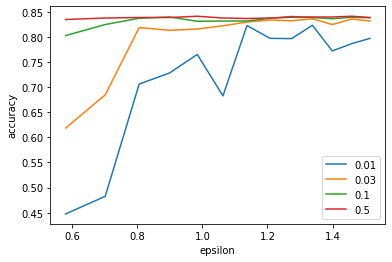

Best accuracy reached: 0.841 with lr=0.5,      
Best epsilon reached:0.5798961926263526 with lr=0.5 and accuracy=:0.8345


In [ ]:
a=0
lr_a=0
lr_e=0
ep=100000
par_accuracy=0
for lr in lrs:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
  accuracies=[]
  eps=[]
  for e in range(num_epochs,15):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, lr, e, sample_rate,
            noise_multiplier, clip_bound, delta)

        eps.append(epsilon)

        #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
        average_loss, total_accuracy = test(model, test_loader)

        accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

        if epsilon<=ep:
          ep=epsilon
          lr_e=lr
          par_accuracy=total_accuracy

        if total_accuracy > a:
          a=total_accuracy
          lr_a=lr

  plt.plot(eps,accuracies, label=lr)

plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print(f'Best accuracy reached: {a} with lr={lr_a},\
      \nBest epsilon reached:{ep} with lr={lr_e} and accuracy=:{par_accuracy}')

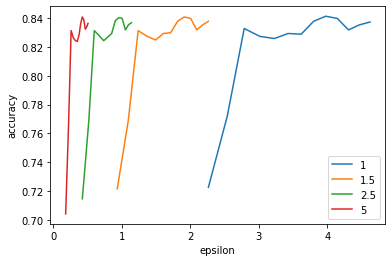

Best accuracy reached: 0.8415 with noise=1,      
Best epsilon reached:0.183496501112943 with noise=5 and accuracy=:0.704


In [ ]:
a=0
noise_a=0
noise_e=0
ep=100000
par_accuracy=0
for n in noises:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
  accuracies=[]
  eps=[]
  for e in range(num_epochs,15):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, e, sample_rate,
            n, clip_bound, delta)

        eps.append(epsilon)

        #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
        average_loss, total_accuracy = test(model, test_loader)

        accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

        if epsilon<=ep:
          ep=epsilon
          noise_e=n
          par_accuracy= total_accuracy

        if total_accuracy > a:
          a=total_accuracy
          noise_a=n

  plt.plot(eps,accuracies, label=n)

plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print(f'Best accuracy reached: {a} with noise={noise_a},\
      \nBest epsilon reached:{ep} with noise={noise_e} and accuracy=:{par_accuracy}')

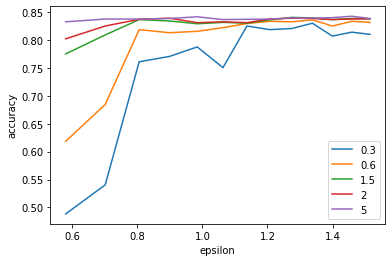

Best accuracy reached: 0.8425 with clip bound=5,      
Best epsilon reached:0.5798961926263526 with clip bound=5 and accuracy=:0.8325


In [ ]:
a=0
bound_a=0
bound_e=0
par_accuracy=0
ep=100000
for b in bounds:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
  accuracies=[]
  eps=[]
  for e in range(num_epochs,15):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, e, sample_rate,
            noise_multiplier, b, delta)

        eps.append(epsilon)

        #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
        average_loss, total_accuracy = test(model, test_loader)

        accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))


        if total_accuracy > a:
          a=total_accuracy
          bound_a=b

        if epsilon<=ep:
          ep=epsilon
          bound_e=b
          par_accuracy=total_accuracy

  plt.plot(eps,accuracies, label=b)

plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print(f'Best accuracy reached: {a} with clip bound={bound_a},\
      \nBest epsilon reached:{ep} with clip bound={bound_e} and accuracy=:{par_accuracy}')


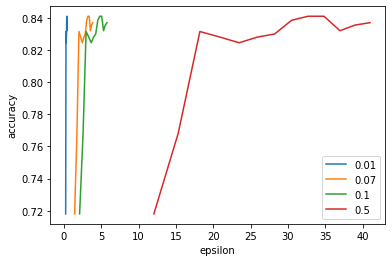

Best accuracy reached: 0.841 with sample rate=0.01,      
Best epsilon reached:0.23715571928532503 with sample rate=0.01 and accuracy=:0.718


In [ ]:
a=0
sample_a=0
sample_e=0
par_accuracy=0
ep=100000
for s in sample_rates:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
  accuracies=[]
  eps=[]
  for e in range(num_epochs,15):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, e, s,
            noise_multiplier, clip_bound, delta)

        eps.append(epsilon)

        #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
        average_loss, total_accuracy = test(model, test_loader)

        accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))


        if total_accuracy > a:
          a=total_accuracy
          sample_a=s

        if epsilon<=ep:
          ep=epsilon
          sample_e=s
          par_accuracy=total_accuracy

  plt.plot(eps,accuracies, label=s)

plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print(f'Best accuracy reached: {a} with sample rate={sample_a},\
      \nBest epsilon reached:{ep} with sample rate={sample_e} and accuracy=:{par_accuracy}')

#### comments

- Test how these parameters (clip bound, sample rate, noise multiplier, learning rate and number of epochs) affect the accuracy of the classifier and its privacy. (You can use the test dataset from `generate_test_data` or the Adult dataset.)


I tested the following parameters:
- sample_rates: $0.01,0.07,0.1,0.5$
- clip_bounds: $ 0.3,0.6,1.5,2.5 $
- noise_multipliers: $1,1.5,2.5,5$
- learning_rates: $0.01,0.03,0.1,0.5$

It is possiblte to notice that smaller $sample\_rates$ results in stronger privacy, whereas low values of $noise$ result in weak privacy. Indeed the best $\epsilon$ reached w.r.t. to different noises was found with noise=1 and the best $\epsilon$ w.r.t. sample_rates was found with sample_rate=0.01.

The higher the $lr$ the more the accuracy rises, however the $\epsilon$ values get bigger too. Nonetheless, this parameter should be tuned taking into account also overfitting issues.



### point 2
How accurate classifier can you build to predict if an individual has an income of at most 50k with the Adult dataset, using DP with $\epsilon=1, \delta = 10^{-5}$? Report your accuracy on a separate test set not used in learning. (Opacus does not offer an easy way to set the parameters to get $\epsilon = 1$, so you must tweak the parameters such that $\epsilon \leq 1$. You can use the function `check_privacy` to evaluate the privacy level at given parameters without actually running the optimisation.)

Hint: the data set includes many categorical variables. In order to use these, you will need to use a one-hot encoding with $n-1$ variables used to denote $n$ values so that $k$th value is represented by value 1 in $k-1$st variable and zeros otherwise. You do not need to use all of the variables for DP training, as a large number of variables increases the noise DP-SGD has to add, while some of the variables may not be useful for the prediction task.


In [ ]:
!pip install CatBoost

In [ ]:
#loading the adult dataset using CatBoost library
import pandas as pd
from catboost.datasets import adult
adult_train, adult_test = adult()

In [ ]:
adult_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


There are 15 different columns, we are interest in incomes less or equal to 50K.
The column will be recoed in $0= \ >50K$ and $1=\ \le 50K$.

Some columns are droped, in particular:
- education: since education_num gives same info
- marital-status: since it's similar to relationship
- native-country: since it involves to many categories and would be a huge dummy variable
- workclass: occupation was kept instead
- fnlwgt: that is the estimated number of people with the same attibutes.

In [ ]:
# to use the genereta data
def cleaner(dataset):
  # remove na
  data= dataset.dropna()
  # remove columns
  data.drop(['education','marital-status','native-country','workclass','fnlwgt'], axis = 1, inplace=True)

  data.replace({'income':'<=50K'},1, inplace=True)
  data.replace({'income':'>50K'},0,inplace=True)

  # return one hot encoding of categorical variables
  oh_occupation = pd.get_dummies(data.occupation, prefix='occupation',drop_first=True)
  oh_relationship = pd.get_dummies(data.relationship, prefix='relationship',drop_first=True)
  oh_race = pd.get_dummies(data.race, prefix='race',drop_first=True)
  oh_sex = pd.get_dummies(data.sex, prefix='sex',drop_first=True)

  data = pd.concat([data, oh_occupation, oh_relationship, oh_race, oh_sex], axis=1)
  data.drop(['occupation','relationship','race','sex'], axis = 1, inplace=True)


  return data


def tensors(train,test):

    x_train = train.loc[:,train.columns!='income']
    y_train = train['income']
    x_test = test.loc[:,test.columns!='income']
    y_test = test['income']

    train_X = torch.from_numpy(x_train.values.astype('float32'))
    train_Y = torch.from_numpy(y_train.values.astype('float32'))
    test_X = torch.from_numpy(x_test.values.astype('float32'))
    test_Y = torch.from_numpy(y_test.values.astype('float32'))

    train_tensor = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y, dtype=torch.float32))
    test_tensor = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y, dtype=torch.float32))


    return train_tensor, test_tensor




In [ ]:
#find values to reach eps=1

check_privacy(0.0215,2,9)

# the above values for sample rate, noise multiplier and epochs gives eps close to 1


(0.9963694169446489, 17.0)

In [ ]:
torch.manual_seed(472368)

train_adult=cleaner(adult_train)
test_adult=cleaner(adult_test)



train_tensor, test_tensor = tensors(train_adult,test_adult)
input_dim = train_tensor[0][0].size(dim=0)

delta = 1e-5

# Learning rate for training
learning_rate = 0.05
# Ratio of the standard deviation to the clipping norm
noise_multiplier = 2
# Clipping norm
clip_bound = 1
# Batch size as a fraction of full data size
sample_rate = 0.0215
# Number of epochs
num_epochs = 9

train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

model = LogisticRegression(input_dim)
epsilon, alpha = train(
      model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sample_rate,
      noise_multiplier, clip_bound, delta)

print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epsilon: 0.9963694169446489, Delta: 1e-05, Alpha: 17.0
Loss: 0.0011950592912367457, Accuracy: 0.7944887118193891


## Task 2: DP Image Classification

Using the above code as a basis, build a DP image classifier for the MNIST dataset. The dataset consists of 28x28 images of handwritten digits (0-9), and the task is to classify which digit each image represents.

A simple implementation of a convolutional neural network for image classification is available (https://www.cs.helsinki.fi/u/oraisa/tml/pytorch_mnist.py), based on the Opacus MNIST tutorial. The example requires the Torchvision (https://pytorch.org/vision/stable/index.html) library, which you should install. The example contains the `SampleConvNet` class that can be used with the `train` and `test` functions from the last exercise, as well as the `get_mnist_dataset` function that loads the MNIST dataset. The dataset is downloaded the first time the function is called and is placed in a directory called `mnist`. By default, the function only loads half of the training data (30 000 images) to save computation time, but the number of training images can be given as a parameter.

i. Train the model using the hyperparameters given below and compute accuracy on test data.
```{python}
clip_bound = 1.5
learning_rate = 0.25
sample_rate = 0.004
noise_multiplier = 1.3
num_epochs = 5
```
The training may take a minute or two. You can pass `verbose=True` to the `train` function to get updates for every completed epoch.
You should get $\epsilon \approx 0.62$ with $\delta = 10^{-5}$ and an accuracy of 80-90%.

ii. Test the impact of the different DP parameters with the aim of creating maximally accurate classifier, given privacy bounds $\epsilon = 1$, $\delta = 10^{-5}$. You can also try changing the optimiser.

Note: Running the learning with many parameters can take a long time, so you should plan your work to keep the number of runs reasonable. The grading of part ii is based on obtaining an overall picture of the impact of key parameters, not the absolute accuracy obtained.

### point 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class SampleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        # x of shape [B, 1, 28, 28]
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

    def train_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        return loss

    def test_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        pred = out.argmax(dim=1, keepdim=True)
        corrects = pred.eq(y.view_as(pred)).sum().item()
        #preds = out > 0 # Predict y = 1 if P(y = 1) > 0.5
        #corrects = torch.tensor(torch.sum(preds == y).item())
        return loss, corrects

def get_mnist_dataset(train_size=30000):
    # Precomputed characteristics of the MNIST dataset
    MNIST_MEAN = 0.1307
    MNIST_STD = 0.3081

    train_full_dataset = datasets.MNIST(
        "mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    )
    train_subsample_loader = DataLoader(
        train_full_dataset, train_size,
        generator=torch.Generator().manual_seed(123456789)
    )
    train_subsample = train_subsample_loader.__iter__().__next__()
    train_dataset = TensorDataset(train_subsample[0], train_subsample[1])

    test_dataset = datasets.MNIST(
        "mnist",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    )
    return train_dataset, test_dataset

In [ ]:
torch.manual_seed(472368)
train_tensor, test_tensor = get_mnist_dataset()
input_dim = train_tensor[0][0].size(dim=0)

delta = 1e-5

# SET PARAMETERS AS ASKED
clip_bound = 1.5
learning_rate = 0.25
sample_rate = 0.004
noise_multiplier = 1.3
num_epochs = 5


train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

model = SampleConvNet()
epsilon, alpha = train(
      model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sample_rate,
     noise_multiplier, clip_bound, delta,verbose=True)

print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epoch 1, loss = 0.0034158958587795496
Epoch 2, loss = 0.002329450799152255
Epoch 3, loss = 0.00231784675270319
Epoch 4, loss = 0.002860528649762273
Epoch 5, loss = 0.0024911228101700544
Epsilon: 0.6188836247099821, Delta: 1e-05, Alpha: 18.0
Loss: 2.090415544807911e-06, Accuracy: 0.8837


### point 2

- Test the impact of the different DP parameters with the aim of creating maximally accurate classifier, given privacy bounds $\epsilon = 1$, $\delta = 10^{-5}$. You can also try changing the optimiser.


I tested the following parameters:
- sample_rates: $0.001,0.008,0.02,0.05$
- clip_bounds: $ 1,1.3,1.6,2 $
- noise_multipliers: $1,1.5,1.8,2$
- learning_rates: $0.02,0.1,0.4 $

I used the check_privacy function to check whether the parameter's combination would give and epsilon within the bounds.

I trained the model with all the different values with epochs ranging from 1 to 6, stored the best parameter value at best accuracy reached and performed a final test with all the best values found that are:
- sample_rates: $0.008$
- clip_bounds:$1.6 $
- noise_multipliers:$ 1.8$
- learning_rates:$0.4$

The final test accuracy reached is: $ 92.06\%$


In [ ]:
# Key parameters
# check that eps is in the bound with check_privacy inside
Max_epoch=7
sample_rates=[0.001,0.008,0.02,0.05]
#fix the rest as point 1
clip_bound = 1.5
learning_rate = 0.25
noise_multiplier = 1.3


a=0
relative_a=0
relative_e=0
ep=100000
relative_accuracy=0
epoch=0
for s in sample_rates:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, s)
  accuracies=[]
  eps=[]
  for e in range(1,Max_epoch):
      if check_privacy(s,noise_multiplier,e)[0]>1:
        print(f'eps={check_privacy(s,noise_multiplier,e)[0]}')
        print('eps > 1, next value')
        continue

      model = SampleConvNet()
      epsilon, alpha = train(model, train_loader, torch.optim.SGD, learning_rate,
                             e, s, noise_multiplier,
                             clip_bound, delta,verbose=True)

      eps.append(epsilon)

      #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
      average_loss, total_accuracy = test(model, test_loader)

      accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))



      if total_accuracy > a:
        a=total_accuracy
        relative_a=s
        epoch=e

print(f'Best accuracy reached: {a} with sample rate={relative_a} with num epoch={e}')


best_sample=relative_a

Epoch 1, loss = 0.009929402731359005
Epoch 1, loss = 0.0022085076197981834
Epoch 2, loss = 0.0023037216160446405
Epoch 1, loss = 0.0023335726000368595
Epoch 2, loss = 0.0022921946365386248
Epoch 3, loss = 0.009373794309794903
Epoch 1, loss = 0.008550972677767277
Epoch 2, loss = 0.002292477758601308
Epoch 3, loss = 0.0022057080641388893
Epoch 4, loss = 0.06852839887142181
Epoch 1, loss = 0.00200805626809597
Epoch 2, loss = 0.002337175654247403
Epoch 3, loss = 0.008757393807172775
Epoch 4, loss = 0.023239241912961006
Epoch 5, loss = 0.002304931404069066
Epoch 1, loss = 0.004126325715333223
Epoch 2, loss = 0.002356006298214197
Epoch 3, loss = 0.04436894878745079
Epoch 4, loss = 0.025714484974741936
Epoch 5, loss = 0.0023076217621564865
Epoch 6, loss = 0.0023360445629805326
Epoch 1, loss = 0.004912002943456173
Epoch 1, loss = 0.00499026570469141
Epoch 2, loss = 0.0036124649923294783
Epoch 1, loss = 0.0052163745276629925
Epoch 2, loss = 0.004007634706795216
Epoch 3, loss = 0.003057226305827

In [ ]:
# Key parameters
# check that eps is in the bound with check_privacy inside
sample_rate=best_sample
#fix the rest
clip_bound = 1.5
learning_rate = 0.25
noise_multipliers = [1,1.5,1.8,2]

a=0
relative_a=0
relative_e=0
ep=100000
relative_accuracy=0
epoch=0
for n in noise_multipliers:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
  accuracies=[]
  eps=[]
  for e in range(1,Max_epoch):
      if check_privacy(sample_rate,n,e)[0]>1:
        print(f'eps={check_privacy(sample_rate,n,e)[0]}')
        print('eps > 1, next value')
        continue

      model = SampleConvNet()
      epsilon, alpha = train(model, train_loader, torch.optim.SGD, learning_rate,
                             e, sample_rate, n,
                             clip_bound, delta,verbose=True)

      eps.append(epsilon)

      #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
      average_loss, total_accuracy = test(model, test_loader)

      accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))



      if total_accuracy > a:
        a=total_accuracy
        relative_a=n
        epoch=e


print(f'Best accuracy reached: {a} with noise={relative_a} and num epoch={e}')


best_noise=relative_a

eps=1.1227253079496566
eps > 1, next value
eps=1.225454324239368
eps > 1, next value
eps=1.3164924401197426
eps > 1, next value
eps=1.4012404012420274
eps > 1, next value
eps=1.4824070580033397
eps > 1, next value
eps=1.5606344928605183
eps > 1, next value
Epoch 1, loss = 0.004412533715367317
Epoch 1, loss = 0.005015907809138298
Epoch 2, loss = 0.003542207181453705
Epoch 1, loss = 0.00527777848765254
Epoch 2, loss = 0.004119069315493107
Epoch 3, loss = 0.003085218369960785
Epoch 1, loss = 0.00432269461452961
Epoch 2, loss = 0.004415187053382397
Epoch 3, loss = 0.0033004707656800747
Epoch 4, loss = 0.0026115127839148045
Epoch 1, loss = 0.005916138645261526
Epoch 2, loss = 0.004562376998364925
Epoch 3, loss = 0.003485021647065878
Epoch 4, loss = 0.004113335162401199
Epoch 5, loss = 0.0037433181423693895
Epoch 1, loss = 0.0049826172180473804
Epoch 2, loss = 0.0028365422040224075
Epoch 3, loss = 0.003754223929718137
Epoch 4, loss = 0.002777892630547285
Epoch 5, loss = 0.0031052655540406704

In [ ]:
# Key parameters
# check that eps is in the bound with check_privacy inside
sample_rate=best_sample
#fix the rest
clip_bounds = [1,1.3,1.6,2]
learning_rate = 0.25
noise_multiplier =best_noise #[1,1.5,1.8,2]


a=0
relative_a=0
relative_e=0
ep=100000
relative_accuracy=0
epoch=0
for c in clip_bounds:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
  accuracies=[]
  eps=[]
  for e in range(1,Max_epoch):
      if check_privacy(sample_rate,noise_multiplier,e)[0]>1:
        print(f'eps={check_privacy(sample_rate,noise_multiplier,e)[0]}')
        print('eps > 1, next value')
        continue

      model = SampleConvNet()
      epsilon, alpha = train(model, train_loader, torch.optim.SGD, learning_rate,
                             e, sample_rate, noise_multiplier,
                             c, delta,verbose=True)

      eps.append(epsilon)

      #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
      average_loss, total_accuracy = test(model, test_loader)

      accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))


      if total_accuracy > a:
        a=total_accuracy
        relative_a=c
        epoch=e



print(f'Best accuracy reached: {a} with clip_bound={relative_a} and num epoch={e}')


best_clip=relative_a

Epoch 1, loss = 0.006051973439753056
Epoch 1, loss = 0.00685131037607789
Epoch 2, loss = 0.004708236549049616
Epoch 1, loss = 0.007022631820291281
Epoch 2, loss = 0.004487135913223028
Epoch 3, loss = 0.0034056389704346657
Epoch 1, loss = 0.005777003709226847
Epoch 2, loss = 0.004598390311002731
Epoch 3, loss = 0.004012326709926128
Epoch 4, loss = 0.002746586687862873
Epoch 1, loss = 0.006735169794410467
Epoch 2, loss = 0.004902177024632692
Epoch 3, loss = 0.003944212105125189
Epoch 4, loss = 0.0043297442607581615
Epoch 5, loss = 0.004205775912851095
Epoch 1, loss = 0.00622700247913599
Epoch 2, loss = 0.002959189238026738
Epoch 3, loss = 0.0039024599827826023
Epoch 4, loss = 0.0027868468314409256
Epoch 5, loss = 0.0031986022368073463
Epoch 6, loss = 0.0038196269888430834
Epoch 1, loss = 0.005214933771640062
Epoch 1, loss = 0.005618259310722351
Epoch 2, loss = 0.00429920107126236
Epoch 1, loss = 0.005879164673388004
Epoch 2, loss = 0.004233975894749165
Epoch 3, loss = 0.00330640235915780

In [ ]:
# Key parameters
# check that eps is in the bound with check_privacy inside
sample_rate=best_sample
#fix the rest
clip_bound = best_clip #[1,1.3,1.6,2]
learning_rates = [0.02,0.1,0.4]
noise_multiplier =best_noise #[1,1.5,1.8,2]


a=0
relative_a=0
relative_e=0
ep=100000
relative_accuracy=0
epoch=0
for lr in learning_rates:
  train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
  accuracies=[]
  eps=[]
  for e in range(1,Max_epoch):
      if check_privacy(sample_rate,noise_multiplier,e)[0]>1:
        print(f'eps={check_privacy(sample_rate,noise_multiplier,e)[0]}')
        print('eps > 1, next value')
        continue

      model = SampleConvNet()
      epsilon, alpha = train(model, train_loader, torch.optim.SGD, lr,
                             e, sample_rate, noise_multiplier,
                             clip_bound, delta,verbose=True)

      eps.append(epsilon)

      #print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
      average_loss, total_accuracy = test(model, test_loader)

      accuracies.append(total_accuracy)
        #print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))



      if total_accuracy > a:
        a=total_accuracy
        relative_a=lr
        epoch=e



print(f'Best accuracy reached: {a} with lr={relative_a} and num epoch={e}')
#,\\nBest epsilon reached:{ep} with sample rate={relative_e} and accuracy=:{par_accuracy}')
best_lr=relative_a

num_ep=epoch

Epoch 1, loss = 0.017505213618278503
Epoch 1, loss = 0.017636630684137344
Epoch 2, loss = 0.016287297010421753
Epoch 1, loss = 0.01749560609459877
Epoch 2, loss = 0.015386807732284069
Epoch 3, loss = 0.0122304642572999
Epoch 1, loss = 0.017363600432872772
Epoch 2, loss = 0.015425271354615688
Epoch 3, loss = 0.012092900462448597
Epoch 4, loss = 0.01050944346934557
Epoch 1, loss = 0.017239270731806755
Epoch 2, loss = 0.014676777645945549
Epoch 3, loss = 0.011041080579161644
Epoch 4, loss = 0.008619886822998524
Epoch 5, loss = 0.007235163357108831
Epoch 1, loss = 0.017502423375844955
Epoch 2, loss = 0.015222418121993542
Epoch 3, loss = 0.012107708491384983
Epoch 4, loss = 0.009112282656133175
Epoch 5, loss = 0.007847233675420284
Epoch 6, loss = 0.006131748668849468
Epoch 1, loss = 0.007171761244535446
Epoch 1, loss = 0.008231784217059612
Epoch 2, loss = 0.004970284178853035
Epoch 1, loss = 0.007986949756741524
Epoch 2, loss = 0.004565325099974871
Epoch 3, loss = 0.003294323105365038
Epoch

In [ ]:
sample_rate=best_sample
#fix the rest
clip_bound = best_clip #[1,1.3,1.6,2]
learning_rate = best_lr #  [0.02,0.1,0.4]
noise_multiplier =best_noise #[1,1.5,1.8,2]


model = SampleConvNet()
epsilon, alpha = train(model, train_loader, torch.optim.SGD, learning_rate,
                             num_ep, sample_rate, noise_multiplier,
                             clip_bound, delta,verbose=True)


print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
average_loss, total_accuracy = test(model, test_loader)

accuracies.append(total_accuracy)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epoch 1, loss = 0.004013249650597572
Epoch 2, loss = 0.0034632643219083548
Epoch 3, loss = 0.002925247186794877
Epoch 4, loss = 0.0028475967701524496
Epoch 5, loss = 0.0034389898646622896
Epoch 6, loss = 0.007345748599618673
Epsilon: 0.6959649507294668, Delta: 1e-05, Alpha: 20.0
Loss: 6.720105830027024e-10, Accuracy: 0.9206


## Task 3: Your own problem in privacy-preserving machine learning

State and solve your own problem related to privacy-preserving machine learning.

You can use code available online, as long as you cite the source.

You can for example try reproducing the results of some interesting paper using their data or your own data, try out some of the privacy attacks, or simply try the above examples using more complex models and/or on different data sets.

If your problem is based on some previous problem, it should extend it in a non-trivial manner (not just running exact same code with new parameters or data).

The evaluation of the project will take the difficulty of your chosen problem into account.

This task is worth as much as two regular problems.

### My problem

My idea was to implement a privacy-preserving classifier for sensitive tweets. In particular I have looked at the following repository: [Link](https://github.com/benchmarkpaper/Benchmarking-Differential-Privacy-and-FederatedLearning-for-Healthcare-Data).
The dataset proposed for sentiment analysis were 3: Depression, Sarcasm and Sexual Harassment.
I worked with the depression dataset tweets: the target column displays 1 for depression and 0 otherwise. The total tweets amount is $3096$, that number was divided in train, validation and test sets.
The csv files are publicly available at the same link.

The model involved made use of the pretrained state of the art architecture BERT, which is 'Bidirectional Encoder Representations from Transformers'. BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text.
The input is a sequence of tokens, which are first embedded into vectors and then processed in the neural network. The output is a sequence of vectors, in which each vector corresponds to an input token with the same index.
In order to build a classification model to 'detect' depression we have to attach to BERT a classifier as a decoder.

I used the part of the repository's code for the data preprocessing, i.e. the tweets --> token --> tensors elaboration.

Then I implemented my own classifier and my own training function.
In the end I was able to reach reasonable accuracy scores
with $\epsilon \le 1$ and setting $ \delta = 10^{-5} $





In [ ]:
!pip install transformers==3

In [ ]:
#!pip install opacus

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import time
import copy
from tqdm import tqdm
import opacus
from opacus import privacy_engine



In [ ]:
#Get data form repository

url = 'https://raw.githubusercontent.com/benchmarkpaper/Benchmarking-Differential-Privacy-and-FederatedLearning-for-Healthcare-Data/master/Data/Depression_Data/dep1_cleaned.csv'

df = pd.read_csv(url)


df.head()

# dataset with tweets and target 1=depressed


,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


### Data preparation

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['target'],
                                                                    random_state=2018,
                                                                    test_size=0.2,
                                                                    stratify=df['target'])

# Using temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.1,
                                                                stratify=temp_labels)

In [ ]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
max_seq_len = 25
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
# Converting Integer Sequences to Tensor

# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Define my personal classifier

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert =bert # passing AutoModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512,128)
        self.linear3 = nn.Linear(128,2)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear1(dropout_output)
        relu_output1 = self.relu(linear_output)
        linear_output2 = self.linear2(relu_output1)
        relu_output2 = self.relu(linear_output2)
        final_layer= self.linear3(relu_output2)
        out= self.softmax(final_layer)

        return out

In [ ]:
model = BertClassifier() #Build the model

In [ ]:
# Optimizer from hugging face transformers
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3,)

#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from opacus.utils.uniform_sampler import UniformWithReplacementSampler


# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

BATCH_SIZE = 8
#SAMPLE_RATE = BATCH_SIZE / len(train_data)
SAMPLE_RATE = 0.005

train_sampler = UniformWithReplacementSampler(
    num_samples=len(train_data),
    sample_rate=SAMPLE_RATE,
)


# DataLoader for train set
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
train_dataloader = DataLoader(train_data, batch_sampler=train_sampler)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=BATCH_SIZE)


In [ ]:
class_wts = np.array([0.68663339, 1.83952452])
weights= torch.tensor(class_wts,dtype=torch.float)
#USING NEGATIVE LOG LIKELIHOOD
cross_entropy  = nn.NLLLoss(weight=weights)

# FIXING PARAMETERS
EPOCHS = 5
DELTA= 1e-5
NOISE=1.5
MAX_GRAD_NORM = 1


In [ ]:
privacy_engine = opacus.PrivacyEngine(
        model,
        sample_rate=SAMPLE_RATE,
        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
        noise_multiplier=NOISE,
        max_grad_norm=MAX_GRAD_NORM,
        secure_rng=False, # Should set to True for production use
    )
privacy_engine._set_seed(123) # Fix randomness, will throw an error with secure_rng=True
privacy_engine.attach(optimizer)

### Define training procedure

In [ ]:
import numpy as np
from tqdm.notebook import tqdm



for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for step, batch in enumerate(tqdm(train_dataloader)):


      inputs = {'sent_id':  batch[0],
                'mask':     batch[1],
                'labels':   batch[2]}

      output = model(inputs['sent_id'], inputs['mask'])

      loss = cross_entropy(output, inputs['labels'])
      total_loss_train += loss.item()

      acc = (output.argmax(dim=1) == inputs['labels']).sum().item()
      total_acc_train += acc

      model.zero_grad()
      loss.backward()

      optimizer.step()


    eps, alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)

    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
      for step, batch in enumerate(tqdm(val_dataloader)):

        inputs = {'sent_id':  batch[0],
                'mask':     batch[1],
                'labels':   batch[2]}
        output= model(inputs['sent_id'], inputs['mask'])
        loss = cross_entropy(output, inputs['labels'])

        total_loss_val += loss.item()

        acc = (output.argmax(dim=1) == inputs['labels']).sum().item()
        total_acc_val += acc

    print(f'Epoch: {epoch + 1} | Train Loss: {total_loss_train /train_seq.shape[0] : .3f} \
                | Train Accuracy: {total_acc_train / train_seq.shape[0]: .3f} \
                | ɛ: {eps:.2f} (α: {alpha})\
                | Val Loss: {total_loss_val / val_seq.shape[0]: .3f} \
                | Val Accuracy: {total_acc_val / val_seq.shape[0]: .3f}')




  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.084                 | Train Accuracy:  0.739                 | ɛ: 0.37 (α: 23.0)                | Val Loss:  0.185                 | Val Accuracy:  0.728


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.122                 | Train Accuracy:  0.753                 | ɛ: 0.41 (α: 23.0)                | Val Loss:  0.207                 | Val Accuracy:  0.728


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.135                 | Train Accuracy:  0.724                 | ɛ: 0.44 (α: 23.0)                | Val Loss:  0.205                 | Val Accuracy:  0.728


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 4 | Train Loss:  0.136                 | Train Accuracy:  0.715                 | ɛ: 0.48 (α: 23.0)                | Val Loss:  0.212                 | Val Accuracy:  0.728


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 5 | Train Loss:  0.138                 | Train Accuracy:  0.746                 | ɛ: 0.51 (α: 23.0)                | Val Loss:  0.226                 | Val Accuracy:  0.728


The best traing accuracy was reached at epoch 2 with $\epsilon = 0.41$. The related validation accuracy reached was $72.8\%$.

I was able to reach a higher level of privacy with similar accuracies to the ones found online.
